In [1]:
import sys
import os

REPO_DIR = os.path.join(os.getcwd(), "../../")

from metient.metient import *
from metient.util import data_extraction_util as dutil

import matplotlib
import torch
import pandas as pd
import numpy as np

custom_colors = ["#9e9e9e","#c27ba0", "#be5742e1", "#6fa8dc", "#e69138", "#6aa84f"]
TRACERX_DATA_DIR = os.path.join(REPO_DIR, 'metient/data/tracerx_nsclc/')
PYCLONE_CLUSTERED_TSVS_DIR = os.path.join(TRACERX_DATA_DIR, 'patient_data', 'pyclone_clustered')
CONIPHER_TREES_DIR = os.path.join(TRACERX_DATA_DIR, 'conipher_outputs', 'TreeBuilding')
OUTPUT_DIR = os.path.join(TRACERX_DATA_DIR, "metient_outputs")

CUDA GPU: False


In [2]:
def find_labeling(ref_var_fn, tree, custom_colors, primary_site, patient_name, output_dir, weights):    
    ref_matrix, var_matrix, unique_sites, idx_to_full_cluster_label = get_ref_var_matrices(ref_var_fn)

    idx_to_cluster_label = dict()
    for ix in idx_to_full_cluster_label:
        og_label_muts = idx_to_full_cluster_label[ix].split(';') # e.g. CUL3:2:225371655:T;TRPM6:9:77431650:C
        if len(og_label_muts) > 3:
            og_label_muts = og_label_muts[:3]
        gene_names = []
        for mut_label in og_label_muts:
            gene_names.append(mut_label.split(":")[0])
        idx_to_cluster_label[ix] = ("_").join(gene_names)
    print(idx_to_cluster_label)
    print(tree.shape)
    G = get_genetic_distance_matrices_from_adj_matrices(tree,idx_to_full_cluster_label, ";")
    print(G)
    if weights.gen_dist == 0.0:
        G = None
    
    print(f"Anatomical sites: {unique_sites}")   

    print_config = PrintConfig(visualize=True, verbose=False, k_best_trees=10)
    evaluate(tree, ref_matrix, var_matrix, unique_sites, primary_site, idx_to_cluster_label,
              weights, print_config, output_dir, patient_name, G=G, O=None,
              weight_init_primary=True, custom_colors=custom_colors, 
              batch_size=6000, solve_polytomies=True)

    
def run_conipher_patient(patient, weights, tsv_dir, tree_dir, output_dir):
    space = "x"*44
    tsv_fn = os.path.join(tsv_dir, f"{patient}_clustered_SNVs.tsv")
    print(f"{space} PATIENT {patient} {space}")
    df = pd.read_csv(tsv_fn, delimiter="\t")
    primary_sites = list(df[df['sample_type']=='primary']['anatomical_site_label'].unique())
    if (len(primary_sites) > 1):
        print("*Multiple primary samples, running metient once for each possible primary*")
    for primary_site in primary_sites:
        print(f"Primary site: {primary_site}")
        run_name = f"{patient}_{primary_site}"
        tree_fn = os.path.join(tree_dir, f"{patient}_conipher_SNVsallTrees_cleaned.txt")
        trees = dutil.get_adj_matrices_from_all_conipher_trees(tree_fn)
        find_labeling(tsv_fn, trees[0], custom_colors, primary_site, run_name, output_dir, weights)


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx PATIENT CRUK0487 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Primary site: primary_SU_T1
{0: 'LRFN5_GABRB1_PTPRG', 1: 'POSTN_IGF2R_PBLD', 2: 'NOXA1_DNAH12_FAM216B', 3: 'LOXL1_PPIG_SEMA3A', 4: 'GTF3A_LLGL1_FAM183B', 5: 'RELN_POT1_FN3K', 6: 'DLC1_RHOU_SIRT2', 7: 'CILP2_EPN1_SPEG', 8: 'EPHA3_CDHR2_NCAPG', 9: 'ADAMTS15_MROH2A_OR5D13', 10: 'CEP112_LOC101928600_LEPRE1', 11: 'MAP4K3_ZNF213_HSPE1', 12: 'MED12L_SND1_GALK1', 13: 'GTPBP1_IL12RB1_COL16A1', 14: 'CPNE9_MTERF_MLYCD', 15: 'COPZ1_MTRR_CXCL12', 16: 'EPM2A_FNDC3B_EYA1', 17: 'KCNN2_TECRL_IQGAP1', 18: 'MARK4_NRP2_TSNARE1', 19: 'CDH6_TMEM8A_MUC2', 20: 'DCN_C8orf58_TEX29', 21: 'POLR3C_TRIO_RARS2', 22: 'ALCAM_CHRM2_KIAA1109', 23: 'TRPM2_SV2C_DOCK10', 24: 'HMCES_MYBPC1_ERAP1'}
torch.Size([25, 25])
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0518, 0.0000, 0.0466,
         0.0000, 0.0415, 0.0000, 0.0000, 0.0363, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0311, 0.0000, 0

/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:289: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)


SOLVE_POLYS True


  0%|          | 0/100 [00:00<?, ?it/s]

T torch.Size([41, 41])
num_nodes_to_label 24


/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:280: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A, remove_self_loops=True), dtype = torch.float32)
100%|██████████| 100/100 [02:13<00:00,  1.33s/it]


# final solutions: 10


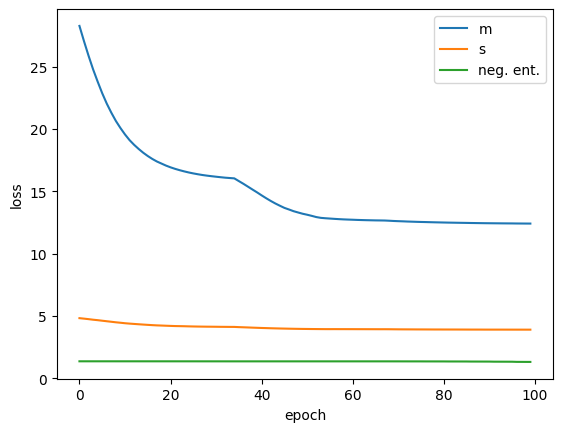

<Figure size 640x480 with 0 Axes>

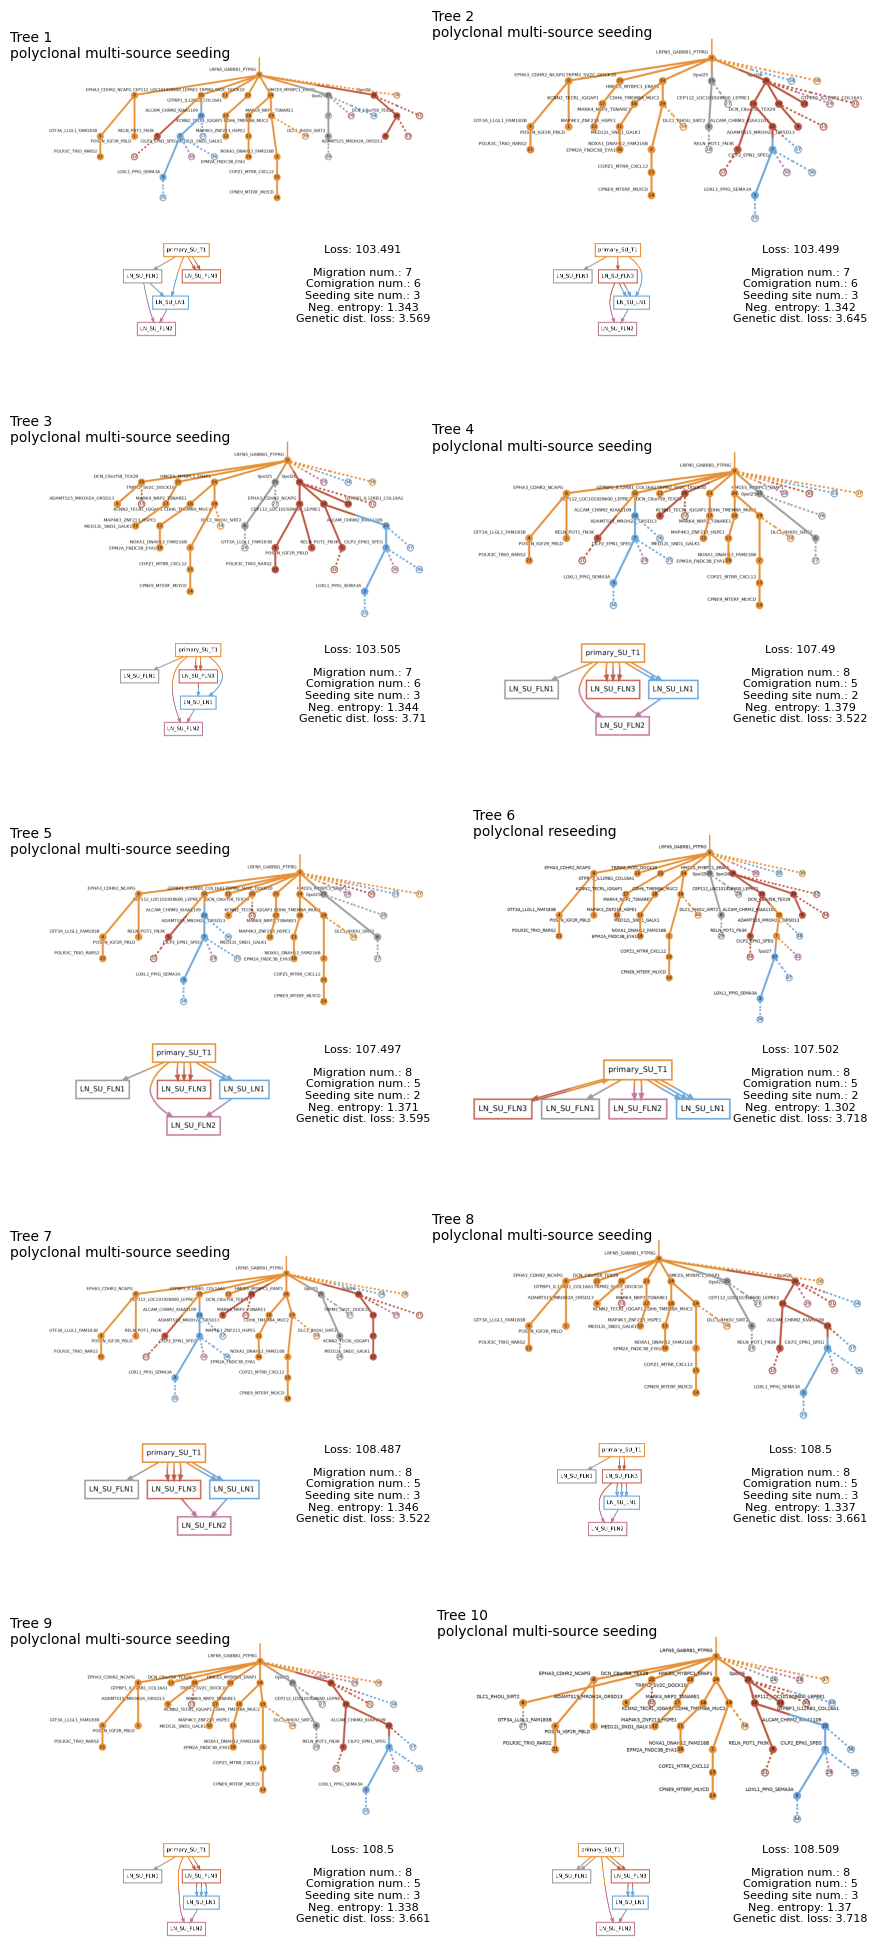

In [3]:
weights = Weights(mig=[10], comig=5.0, seed_site=[1.0], gen_dist=0.1, organotrop=0.0)

run_conipher_patient("CRUK0487", weights, PYCLONE_CLUSTERED_TSVS_DIR, CONIPHER_TREES_DIR, OUTPUT_DIR)